In [2085]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as smapi

import scipy.stats
from tqdm.notebook import tqdm

In [2086]:
def get_na_cols(df):
    out = []
    for col in df.columns:
        if df[col].isna().any():
            out.append(col)
    return out

def print_na(df):
    there_is_nan = False
    for col in df.columns:
        if df[col].isna().sum() != 0:
            print('Column', col, 'has', df[col].isna().sum(), 'NaN values')
            there_is_nan = True
    if not there_is_nan:
        print(f"There's no NaN values")

In [2087]:
train_df = pd.read_csv(r'data\train.csv')
test_df = pd.read_csv(r'data\test.csv')

In [2088]:
train_df.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
814,815,50,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,116000
878,879,85,RL,88.0,11782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,6,2010,WD,Normal,148000
1377,1378,50,RL,60.0,10998,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,117000
1058,1059,60,RL,96.0,11308,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,335000
842,843,80,RL,82.0,9020,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,5,2008,WD,Normal,174900
545,546,50,RL,NaN,13837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,229000
338,339,20,RL,91.0,14145,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,400,5,2006,WD,Normal,202500
27,28,20,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,306000
1183,1184,30,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,120000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


# Замечание насчёт распределения целевой переменной

In [2089]:
sp = train_df['SalePrice'].copy()

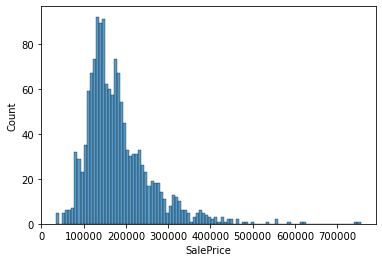

In [2090]:
sns.histplot(sp, bins = 100);

Видим "скошенность" влево и кучку выбросов. Первое должно решаться логарифмированием

In [2091]:
# Это пригодится позже. Поясню ближе к делу
sp = np.log(sp)
sp_mean = sp.mean()
sp_std = sp.std()
# Заодно и стандартизируем
sp = (sp - sp.mean()) / sp.std()

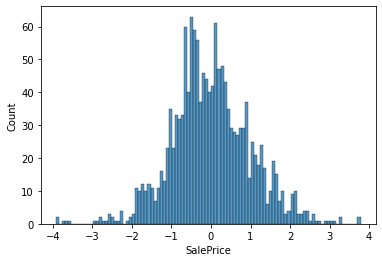

In [2092]:
sns.histplot(sp, bins = 100);

Выбросы сильно портить жизнь нам не должны, да и вообще не понятно справедливо ли я назвал их выбросами, т.к размер выборки достаточно велик, чтоб появилось нечто подобное. Посмотрим что скажет критерий Шапиро-Уилка

In [2093]:
print('p-value =', scipy.stats.shapiro(sp)[1])

p-value = 1.1507501795904318e-07


Критерий довольно уверенно отвергает нормальность. Посмотрим на квантиль-квантильный график

C:\Users\onton\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


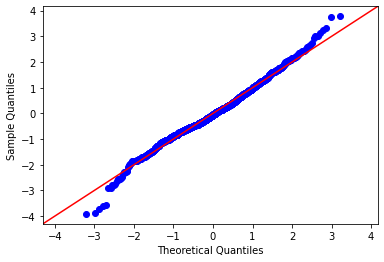

In [2094]:
smapi.qqplot(sp, line = '45');

В общем-то, я с чистой совестью заключаю, что отклонения от нормальности незначительны и в случае чего мы будем полагать цены нормально распределёнными 

In [2095]:
train_df['SalePrice'] = sp.copy()

# Разбираемся с отсутствующими значениями 

**PoolQC и PoolArea**

In [2096]:
train_df['PoolQC'].nunique()

3

In [2097]:
for pqc, sub_df in train_df.groupby('PoolQC'):
    print(pqc, ':', sep = '')
    print(sub_df['SalePrice'].values)

Ex:
[0.85940239 3.74785729]
Fa:
[0.20578552 1.01430317]
Gd:
[ 0.06350686 -0.10294559  1.25263247]


In [2098]:
train_df['SalePrice'].describe()

count    1.460000e+03
mean     2.477124e-14
std      1.000000e+00
min     -3.914887e+00
25%     -6.232379e-01
50%     -5.644090e-02
75%      6.250575e-01
max      3.781237e+00
Name: SalePrice, dtype: float64

Здесь отсутствуещее значение означает отсуствие бассейна. Несмотря на то, что наличие бассейна, казалось бы, априори должно означать, что дом стоит до черта, видим, что цена домов с бассейном не всегда превосходит даже медианы, так что с чистой совестью избавляемся от этого признака (и, как следствие от признака PoolArea)

In [2099]:
to_drop = ['PoolQC', 'PoolArea']

**MiscFeature**    

Отражает некоторые блага, которые было решено не выносить в отдельный признак. 

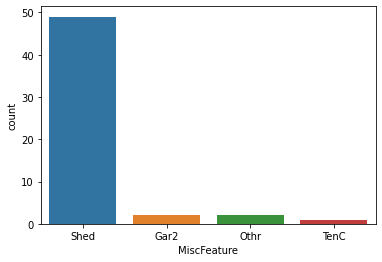

In [2100]:
sns.countplot(x = train_df['MiscFeature']);

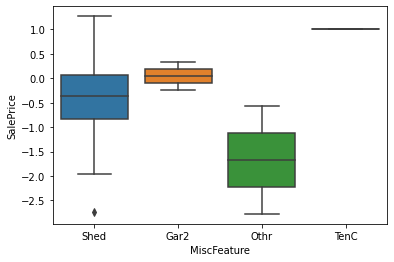

In [2101]:
sns.boxplot(x = train_df['MiscFeature'], y = train_df['SalePrice']);

Наличие сарая мало говорит о цене на соответствующий дом, а всё остально слишком малочисленно, так что

In [2102]:
to_drop.append('MiscFeature')

**Fence**

Качество забора. Здесь отсутствующее значение означает просто отсутствие забора, так что просто меняем их на нули

In [2103]:
train_df.fillna(value = {'Fence': 0}, inplace = True)

**Alley**

Аналогично

In [2104]:
train_df.fillna(value = {'Alley': 0}, inplace = True)

**FireplaceQu**

Качество камина. Всё ещё аналогично

In [2105]:
train_df.fillna(value = {'FireplaceQu': 0}, inplace = True)

**LotFrontage** 

Порождение Сатаны, не поддающееся адекватному описанию на любом из существующих языков. На kaggle описывается так: "Linear feet of street connected to property". Видно, что речь идёт о каких-то футах, которые прилегают к какой-то там собственности, однако все попытки сложить это всё в адекватное предложение потерпели крах, несмотря на то, что перевода я просил у трех уважаемых в переводческих кругах людей (у всех как минимум слабенькая 4 в аттестате). Всё, что удалось установить, так это то, что речь идёт, вероятно, о чём-то вроде периметра участка. Логично предположить, что должна быть заметная корреляция с площадью всего участка.

In [2106]:
train_df['LotFrontage'].corr(train_df['LotArea'])

0.42609501877180816

Что-то как-то не особо они коррелируют. Порисуем графики 

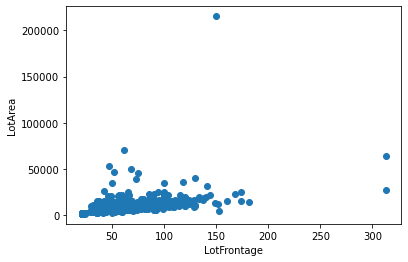

In [2107]:
plt.scatter(train_df['LotFrontage'], train_df['LotArea']);
plt.xlabel('LotFrontage');
plt.ylabel('LotArea');

Кажется, корреляция сильно "портится" выбросами. Пересчитаем её, убрав несколько выбросов

In [2108]:
mask = ~train_df['LotFrontage'].isna()
for i in range(1, 6):
    print(f'Значение корреляции Пирсона после удаления {i * 5} выбросов:')
    # Корреляция инвариантна относительно перестановок выборок
    print(train_df['LotFrontage'][mask].sort_values()[:-i * 5].corr(
                                      train_df['LotArea'][mask].sort_values()[: -i * 5]))

Значение корреляции Пирсона после удаления 5 выбросов:
0.5713688518429144
Значение корреляции Пирсона после удаления 10 выбросов:
0.6326733144995496
Значение корреляции Пирсона после удаления 15 выбросов:
0.6567477073616167
Значение корреляции Пирсона после удаления 20 выбросов:
0.6611616614094615
Значение корреляции Пирсона после удаления 25 выбросов:
0.6838339903346989


Видимо, эти признаки коррелируют достаточно сильно для того, чтоб в качестве первичной меры можно было LotFrontage пока что удалить. В случае, если конечное качество модели не будет нас устраивать, мы к этому вернёмся.

Спойлер: в итоге, с этим признаком лучше

In [2109]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(value = train_df['LotFrontage'].median())
# to_drop.append('LotFrontage')

**MasVnrType и MasVnrArea**

Признаки связаны в том смысле, что первое - тип кирпичной кладки (и Nan в случае, если такового нет), а второе - площадь той самой кладки. Снова заполняем нулями 

In [2110]:
train_df.fillna(value = {'MasVnrType': 0, 'MasVnrArea': 0}, inplace = True)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 и BsmtFinType2**

Отсутствующие значения означают отсутствие подвала, так что аналогично

In [2111]:
train_df.fillna(value = {'BsmtQual': 0, 'BsmtCond': 0, 'BsmtExposure': 0,
                         'BsmtFinType1': 0, 'BsmtFinType2': 0}, inplace = True)

**GarageYrBlt** 

Год, в котором был построен гараж. Поглядим на зависимость цены на жильё от года постройки гаража 

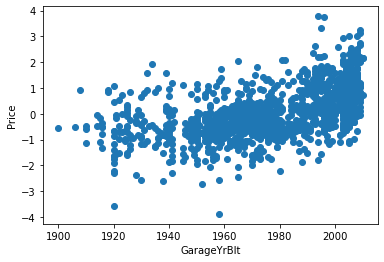

In [2112]:
plt.scatter(train_df['GarageYrBlt'], train_df['SalePrice']);
plt.xlabel('GarageYrBlt');
plt.ylabel('Price');

Для каждого конкретного года постройки гаража цены на соответствующие дома распределены плюс-минус одинаково. Да, дома с гаражом, построенным где-то начиная с 90-ых годов в среднем стоят несколько больше, однако разумно предполагать, что связано это с тем, что соответствующие дома были построены позже. В качестве первичной меры снова удалим и снова вернёмся к этому, если итоговое качество модели нас не устроит.

In [2113]:
to_drop.append('GarageYrBlt')

**GarageType, GarageFinish, GarageQual, GarageCond**

Все эти переменные содержат некоторую информацию о гараже. Отсутствующие значение означает отсутствие гаража, так что снова заключаем, что нули наше всё

In [2114]:
train_df.fillna(value = {'GarageType': 0, 'GarageFinish': 0, 
                         'GarageQual': 0, 'GarageCond': 0}, inplace = True)

**Id**

Очевидно, просто удаляем. Надо было с этого, в общем-то, начинать

In [2115]:
to_drop.append('Id')

**Electrical**

Отсутствует только одно значение, так что просто удаляем соответствующую строку (тем паче, что в тестовом наборе все значения заполнены)

In [2116]:
train_df.drop(train_df[train_df['Electrical'].isna()].index, 
              axis = 0, inplace = True)

# Аналогичная отчистка тестовых данных 
Слегка передохнём и сразу проделаем те же манипуляции с тестовым набором

In [2117]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [2118]:
# Заполняем нулями те отсутствующие значения, для которых это разумно
test_df.fillna(value = {'Fence': 0, 'FireplaceQu': 0, 'Alley': 0}, inplace = True)
test_df.fillna(value = {'BsmtQual': 0, 'BsmtCond': 0, 'BsmtExposure': 0,
                        'BsmtFinType1': 0, 'BsmtFinType2': 0}, inplace = True)
test_df.fillna(value = {'GarageType': 0, 'GarageFinish': 0, 
                         'GarageQual': 0, 'GarageCond': 0}, inplace = True)
test_df.fillna(value = {'MasVnrType': 0, 'MasVnrArea': 0}, inplace = True)

In [2119]:
print_na(test_df)

Column MSZoning has 4 NaN values
Column LotFrontage has 227 NaN values
Column Utilities has 2 NaN values
Column Exterior1st has 1 NaN values
Column Exterior2nd has 1 NaN values
Column BsmtFinSF1 has 1 NaN values
Column BsmtFinSF2 has 1 NaN values
Column BsmtUnfSF has 1 NaN values
Column TotalBsmtSF has 1 NaN values
Column BsmtFullBath has 2 NaN values
Column BsmtHalfBath has 2 NaN values
Column KitchenQual has 1 NaN values
Column Functional has 2 NaN values
Column GarageCars has 1 NaN values
Column GarageArea has 1 NaN values
Column SaleType has 1 NaN values


Как видим, отсутствующих значений всё ещё хватает, так что
# Заполнение отсутствующих значений в тестовом наборе

Все эти признаки, несмотря на то, что MSSubClass заполнены числовыми (и в одном случае даже вещественными) значениями категориальные и сложно придумать что-то лучше, чем заполнить отсутствующие значения модой

In [2120]:
cols_to_fill = get_na_cols(test_df)
for feature in cols_to_fill:
    test_df.fillna(value = {feature: test_df[feature].value_counts().index[0]}, inplace = True)

In [2121]:
print_na(test_df)

There's no NaN values


# Анализ переменных

## Анализ одиночных переменных 
Начнём с категориальных признаков.

In [2122]:
cat_features = np.array(train_df.columns[train_df.dtypes == 'object'])
# Добавляем категориальные переменные, что маскируются под целочисленные
cat_features = np.append(cat_features, ['MSSubClass', 'OverallQual', 'OverallCond', 
                                        'HalfBath', 'MiscVal', 'BsmtHalfBath',
                                        'YearBuilt', 'YearRemodAdd', 
                                        'BedroomAbvGr', 'KitchenAbvGr',
                                        'Fireplaces', 'YrSold', 'MoSold',
                                        'BsmtFullBath', 'TotRmsAbvGrd',
                                        'GarageCars', 'FullBath'])
real_features = list(set(train_df.columns) - set(cat_features))

Ко многим признакам придётся применять унитарное кодирование. Так как датасет довольно маленький, плодить много признаков не хотелось бы в связи с чем редковстречающиеся значения признаков мы просто удаляем:

In [2123]:
def replace_low_freq(df, features = [], percent = 0.005):
    _len = len(df)
    for feature in features:
        freqs = df[feature].value_counts() / _len
        for val in freqs.index:
            if freqs[val] < percent:
                df.loc[df[feature] == val, feature] = None
replace_low_freq(train_df, features = cat_features)
replace_low_freq(test_df, features = cat_features)

Также немножко перестрахуемся очень сильно и заменим на None значения признаков, что встречаются в тестовом наборе, но не встречаются в тренировочном (и наоборот). Нужно это, очевидно, для того, чтоб модели, которая обучится на тренировочном наборе не поплохело при виде признака, который прежде ей не встречался (во время попыток предсказать цены на тестовом наборе модели не поплохело от того, что каких-то признаков просто нет)

In [2124]:
# Для всех категориальных признаков
for feature in cat_features:
    # Для всех значений кат. признака, что встречается в тестовом наборе
    for feature_val in test_df[feature].unique():
        # Если такое значение не встречается в тренировочном наборе
        if feature_val not in train_df[feature].unique():
            # Заменить на None
            test_df.loc[test_df[feature] == feature_val, feature] = None
            
# Аналогично, но наоборот
for feature in cat_features:
    for feature_val in train_df[feature].unique():
        if feature_val not in test_df[feature].unique():
            train_df.loc[train_df[feature] == feature_val, feature] = None

Так же нам пригодится F-тест

In [2125]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    # По умолчанию numpy считает смещённую оценку выборочной дисперсии. 
    # параметр ddof, приравненый к единице, исправляет это недоразумение 
    f_stat = np.var(x, ddof = 1) / np.var(y, ddof = 1) 
    dfn = x.size - 1 
    dfd = y.size - 1 
    p_value = 1 - scipy.stats.f.cdf(f_stat, dfn, dfd) 
    return f_stat, p_value

Крайне удобно иметь под рукой такую функцию

In [2126]:
def replace_values(df1, df2 = None, col = '', val_to_rep = None, replace_with = None):
    '''
    В столбце col DataFrame'ов df1 и df2 заменяет все встречающиеся val_to_rep 
    на replace_with
    '''
    df1.loc[df1[col] == val_to_rep, col] = replace_with
    if df2 is not None:
        df2.loc[df2[col] == val_to_rep, col] = replace_with

In [2127]:
# Список признаков, к которым будет применено унитарное кодирование
to_get_dummies = []
# Список признаков, которые будут удалены
to_drop = []
# Список признаков, к которым будет применён Label Encoder. Как это грамотно переводится 
# на русский язык я так и не нагуглил
label_encoded = []

**OverallQual**

In [2128]:
train_df['OverallQual'].value_counts()

5.0     396
6.0     374
7.0     319
8.0     168
4.0     116
9.0      43
3.0      20
10.0     18
Name: OverallQual, dtype: int64

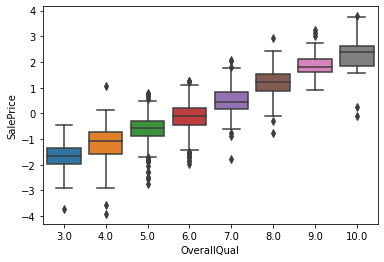

In [2129]:
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = train_df);

Поскольку признак является оценкой качеству отделки дома, а с возрастанием цены довольно явно в среднем растёт и цена на соотсветствующие дома, оставим всё как есть за тем лишь исключением, что вычтем из всего столбца *минимальную из имещихся оценок - 1*, чтоб всё начиналось с 1

In [2130]:
train_df['OverallQual'] -= train_df['OverallQual'].min() - 1
test_df['OverallQual'] -= test_df['OverallQual'].min() - 1
label_encoded.append('OverallQual')

Некоторые значения отсутствуют и это не будет исправлено унитарным кодированием (что логично, ведь не будет унитарного кодирования), так что заменим их модой

In [2131]:
train_df.loc[train_df['OverallQual'].isna(), 'OverallQual'] = 5.0
test_df.loc[test_df['OverallQual'].isna(), 'OverallQual'] = 5.0

**OverallCond**

In [2132]:
train_df['OverallCond'].value_counts()

5.0    820
6.0    252
7.0    205
8.0     72
4.0     57
3.0     25
9.0     22
Name: OverallCond, dtype: int64

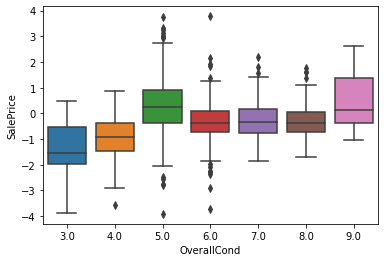

In [2133]:
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = train_df);

О домах, получившие оценку 5, нельзя сказать ничего, кроме того, что она почти всегда больше -2. Понятно, что признак слабоинформативный 

In [2134]:
replace_values(train_df, test_df, 'OverallCond', 5, None)

Дальше, кажется, что цены на дома, получившие оценки 7, 8 распределены +- одинаково

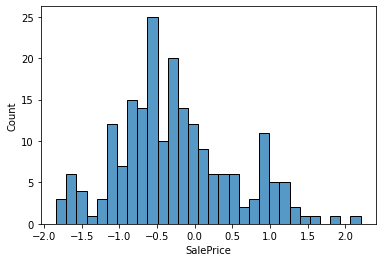

In [2135]:
sns.histplot(train_df[train_df['OverallCond'] == 7.0]['SalePrice'], bins = 30);

In [2136]:
scipy.stats.shapiro(train_df[train_df['OverallCond'] == 7.0]['SalePrice'])

ShapiroResult(statistic=0.9756020307540894, pvalue=0.0012398198014125228)

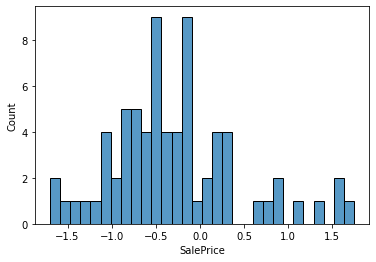

In [2137]:
sns.histplot(train_df[train_df['OverallCond'] == 8.0]['SalePrice'], bins = 30);

In [2138]:
scipy.stats.shapiro(train_df[train_df['OverallCond'] == 8.0]['SalePrice'])

ShapiroResult(statistic=0.9493479132652283, pvalue=0.005758518353104591)

Распределение домов, получивших оценку 7 на вид не сильно отклоняется от нормального и тест Шапиро-Уилка даёт не самое маленькое p-value. Дома, получившие оценку 8 на вид не распределены нормально, однако pvalue ещё выше.

В силу вышесказанного, считаю оправданным использовать тесты, предполагающие нормальность распределения, ибо умный дядя сказал, что многие тесты слабо чувствительны к отклонениям от нормальности, а умные дяди врать не станут 

In [2139]:
x = train_df[train_df['OverallCond'] == 7.0]['SalePrice']
y = train_df[train_df['OverallCond'] == 8.0]['SalePrice']
f_test(x, y)

(1.1095103510979378, 0.30986904437973084)

In [2140]:
scipy.stats.ttest_ind(x, y)

Ttest_indResult(statistic=0.2857827354913163, pvalue=0.775259677898033)

В обоих случаях p_value > 0.05, так что различать дома с такими оценками смысла мало.

In [2141]:
replace_values(train_df, test_df, 'OverallCond', 8.0, 7.0)

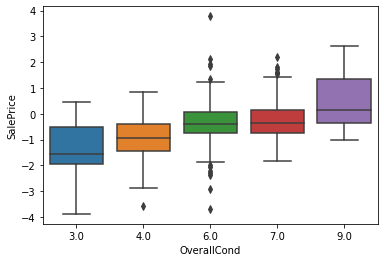

In [2142]:
sns.boxplot(x = 'OverallCond', y = 'SalePrice', data = train_df);

Аналогичные предположения возникают теперь насчёт домов, получивших оценки 6 и 7, однако в первом случае имеем заметное кол-во выбросов в силу чего объединять эти оценки в одну не хотелось бы, так что оставим как есть

In [2143]:
# Вообще, не вижу особых причин предпочитать унитарное кодирование 
# Label Encoding'у, но что-то мне подсказывает, что всё-таки лучше так
to_get_dummies.append('OverallCond')

**BsmtFullBath**

In [2144]:
train_df['BsmtFullBath'].value_counts()

0.0    855
1.0    588
2.0     15
Name: BsmtFullBath, dtype: int64

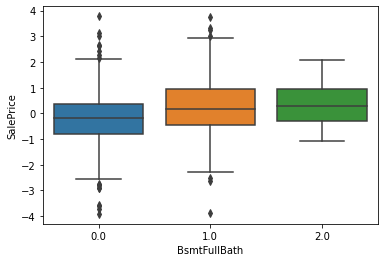

In [2145]:
sns.boxplot(x = 'BsmtFullBath', y = 'SalePrice', data = train_df);

Вообще, "двойки" распределены так, что, в общем-то дают некоторую содержательную информацию о цене, но таковых домов очень мало. Для начала попробуем вынести в отдельный признак, а потом, как говорится, будем посмотреть

In [2146]:
replace_values(train_df, test_df, 'BsmtFullBath', 0.0, None)
replace_values(train_df, test_df, 'BsmtFullBath', 1.0, None)
to_drop.append('BsmtFullBath')

**TotRmsAbvGrd**

In [2147]:
train_df['TotRmsAbvGrd'].value_counts()

6.0     402
7.0     328
5.0     275
8.0     187
4.0      97
9.0      75
10.0     47
11.0     18
3.0      17
Name: TotRmsAbvGrd, dtype: int64

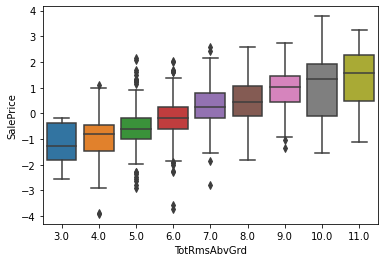

In [2148]:
sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = train_df);

По мере возрастания признака, возрастает и средняя цена на дома. Осталось только привести все значения из отрезка [3: 11] в отрезок [1:9] потому что мне так больше нравится

In [2149]:
train_df['TotRmsAbvGrd'] -= train_df['TotRmsAbvGrd'].min() - 1
test_df['TotRmsAbvGrd'] -= test_df['TotRmsAbvGrd'].min() - 1
label_encoded.append('TotRmsAbvGrd')

Отсутствующие значения заполняем модой

In [2150]:
train_df.loc[train_df['TotRmsAbvGrd'].isna(), 'TotRmsAbvGrd'] = 6.0
test_df.loc[test_df['TotRmsAbvGrd'].isna(), 'TotRmsAbvGrd'] = 6.0

**GarageCars**

In [2151]:
train_df['GarageCars'].value_counts()

2.0    823
1.0    369
3.0    181
0.0     81
Name: GarageCars, dtype: int64

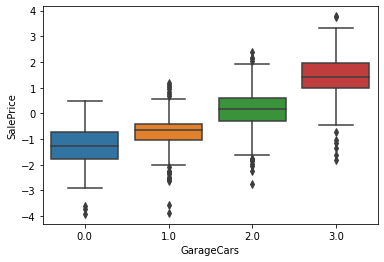

In [2152]:
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = train_df);

Аналогично, но на этот раз приводим к целочисленному типу

In [2153]:
label_encoded.append('GarageCars')

**BsmtHalfBath**

In [2154]:
train_df['BsmtHalfBath'].value_counts()

0.0    1377
1.0      80
Name: BsmtHalfBath, dtype: int64

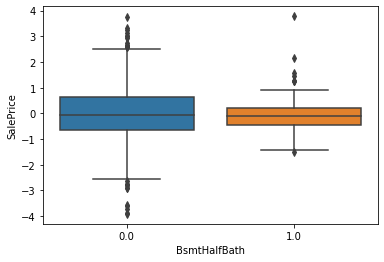

In [2155]:
sns.boxplot(x = 'BsmtHalfBath', y = 'SalePrice', data = train_df);

То, что этот признак равен нулю не даёт нам никакой информации о цене дома, но не исключено, что признак полезен, если взять во внимание остальные признаки, так что мы ещё можем к этому вернуться

In [2156]:
replace_values(train_df, test_df, 'BsmtHalfBath', 0.0, None)

In [2157]:
to_get_dummies.append('BsmtHalfBath')

**YearBuilt**

In [2158]:
train_df['YearBuilt'].value_counts()

2006.0    66
2005.0    64
2004.0    54
2007.0    49
2003.0    45
1976.0    33
1977.0    32
1920.0    30
1959.0    26
1998.0    25
1999.0    25
2000.0    24
1954.0    24
1958.0    24
1970.0    24
1965.0    24
1972.0    23
2002.0    23
2008.0    23
1971.0    22
1968.0    22
2001.0    20
1957.0    20
1950.0    20
1994.0    19
1962.0    19
1966.0    18
1940.0    18
1995.0    18
1910.0    17
1960.0    17
1993.0    17
1955.0    16
1967.0    16
1925.0    16
1963.0    16
1978.0    16
1996.0    15
1941.0    15
1964.0    15
1961.0    14
1956.0    14
1969.0    14
1997.0    14
1948.0    14
1992.0    13
1953.0    12
1973.0    11
1980.0    10
1900.0    10
1974.0    10
1915.0    10
1926.0     9
1984.0     9
1979.0     9
1930.0     9
1939.0     8
1922.0     8
1975.0     8
Name: YearBuilt, dtype: int64

Мера, опять же, первичная

In [2159]:
to_drop.append('YearBuilt')

**YearRemodAdd**

Дата реконструкции. Совпадает с годом постройки, если реконструкций не было

In [2160]:
train_df['YearRemodAdd'].nunique()

48

Слишком много уникальных значений, что меня, бедного и неопытного несколько пугает, так что

In [2161]:
to_drop.append('YearRemodAdd')

**FullBath**

In [2162]:
train_df['FullBath'].value_counts()

2.0    767
1.0    650
3.0     33
Name: FullBath, dtype: int64

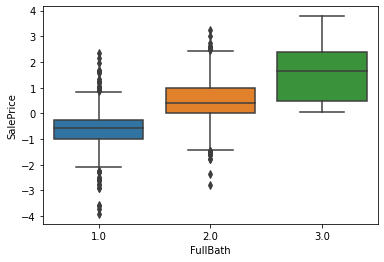

In [2163]:
sns.boxplot(x = 'FullBath', y = 'SalePrice', data = train_df);

In [2164]:
replace_values(train_df, test_df, 'FullBath', 1, None) 
replace_values(train_df, test_df, 'FullBath', 2, None) 

In [2165]:
to_get_dummies.append('FullBath')

**HalfBath**

In [2166]:
train_df['HalfBath'].value_counts()

0    913
1    534
2     12
Name: HalfBath, dtype: int64

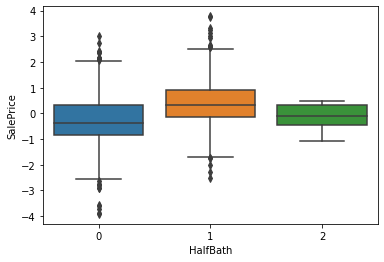

In [2167]:
sns.boxplot(x = 'HalfBath', y = 'SalePrice', data = train_df);

In [2168]:
replace_values(train_df, test_df, 'HalfBath', 1, None) 
replace_values(train_df, test_df, 'HalfBath', 2, None) 
to_drop.append('HalfBath')

**BedroomAbvGr**

In [2169]:
train_df['BedroomAbvGr'].value_counts()

3.0    803
2.0    358
4.0    213
1.0     50
5.0     21
Name: BedroomAbvGr, dtype: int64

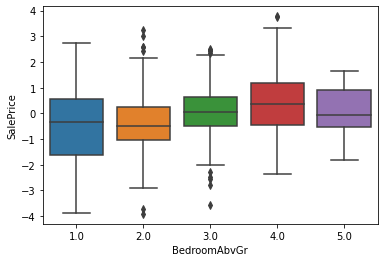

In [2170]:
sns.boxplot(x = 'BedroomAbvGr', y = 'SalePrice', data = train_df);

In [2171]:
to_drop.append('BedroomAbvGr')

**KitchenAbvGr**

In [2172]:
train_df['KitchenAbvGr'].value_counts()

1.0    1391
2.0      65
Name: KitchenAbvGr, dtype: int64

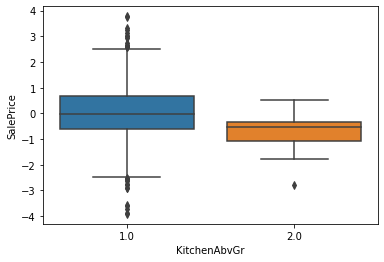

In [2173]:
sns.boxplot(x = 'KitchenAbvGr', y = 'SalePrice', data = train_df);

Опять же, тот факт, что этот признак равен единице нам ничего о цене на соот-щий дом не говорит.

In [2174]:
replace_values(train_df, test_df, 'KitchenAbvGr', 1.0, None)
to_get_dummies.append('KitchenAbvGr')

**MiscVal**

In [2175]:
train_df['MiscVal'].value_counts()

0.0    1407
Name: MiscVal, dtype: int64

In [2176]:
to_drop.append('MiscVal')

**Fireplaces**

In [2177]:
train_df['Fireplaces'].value_counts()

0.0    689
1.0    650
2.0    115
Name: Fireplaces, dtype: int64

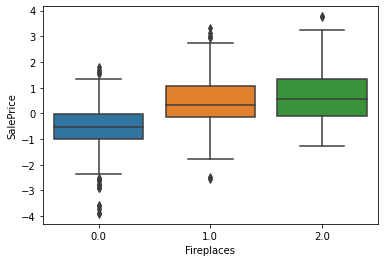

In [2178]:
sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = train_df);

In [2179]:
train_df.loc[train_df['Fireplaces'].isna(), 'Fireplaces'] = 0.0
test_df.loc[test_df['Fireplaces'].isna(), 'Fireplaces'] = 0.0
label_encoded.append('Fireplaces')

**YrSold**

In [2180]:
train_df['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    303
2010    175
Name: YrSold, dtype: int64

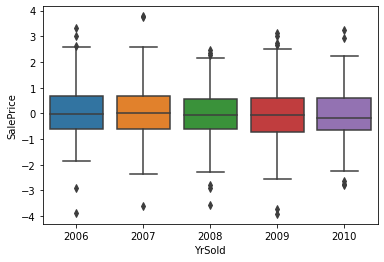

In [2181]:
sns.boxplot(x = 'YrSold', y = 'SalePrice', data = train_df);

Всё распределено +- одинаково, так что пока что

In [2182]:
to_drop.append('YrSold')

**MoSold**

In [2183]:
train_df['MoSold'].value_counts()

6     253
7     234
5     203
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

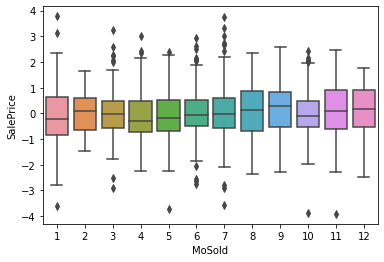

In [2184]:
sns.boxplot(x = 'MoSold', y = 'SalePrice', data = train_df);

Аналогично

In [2185]:
to_drop.append('MoSold')

**MSZoning**:

In [2186]:
train_df['MSZoning'].value_counts()

RL         1150
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

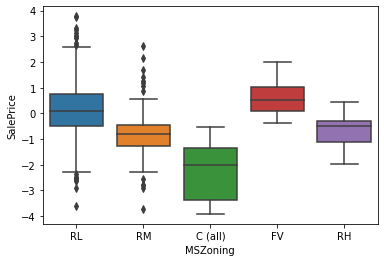

In [2187]:
sns.boxplot(x = 'MSZoning', y = 'SalePrice', data = train_df);

In [2188]:
replace_values(train_df, test_df, 'MSZoning', 'RL', None)
replace_values(train_df, test_df, 'MSZoning', 'RM', None)

to_get_dummies.append('MSZoning')

**Street**

In [2189]:
train_df['Street'].value_counts()

Pave    1453
Name: Street, dtype: int64

In [2190]:
to_drop.append('Street')

**Alley**

In [2191]:
train_df['Alley'].value_counts()

0       1368
Grvl      50
Pave      41
Name: Alley, dtype: int64

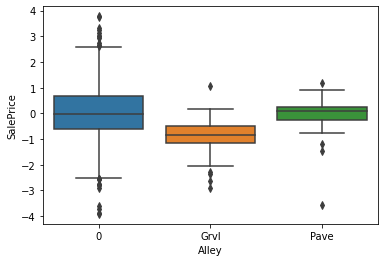

In [2192]:
sns.boxplot(x = 'Alley', y = 'SalePrice', data = train_df);

In [2193]:
replace_values(train_df, test_df, 'Alley', 0, None)

In [2194]:
to_get_dummies.append('Alley')

**LotShape**

In [2195]:
train_df['LotShape'].value_counts()

Reg    924
IR1    484
IR2     41
Name: LotShape, dtype: int64

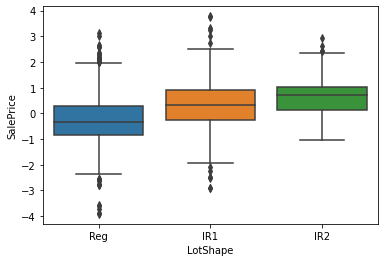

In [2196]:
sns.boxplot(x = 'LotShape', y = 'SalePrice', data = train_df);

In [2197]:
replace_values(train_df, test_df, 'LotShape', 'Reg', None)
replace_values(train_df, test_df, 'LotShape', 'IR1', None)

In [2198]:
to_get_dummies.append('LotShape')

**LandContour**

In [2199]:
train_df['LandContour'].value_counts()

Lvl    1310
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

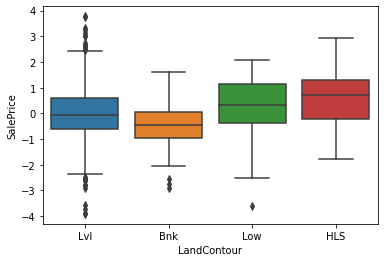

In [2200]:
sns.boxplot(x = 'LandContour', y = 'SalePrice', data = train_df);

In [2201]:
replace_values(train_df, test_df, 'LandContour', 'Lvl', None)

In [2202]:
to_get_dummies.append('LandContour')

**Utilities**

In [2203]:
train_df['Utilities'].value_counts()

AllPub    1458
Name: Utilities, dtype: int64

In [2204]:
to_drop.append('Utilities')

**LotConfig**

In [2205]:
train_df['LotConfig'].value_counts()

Inside     1051
Corner      263
CulDSac      94
FR2          47
Name: LotConfig, dtype: int64

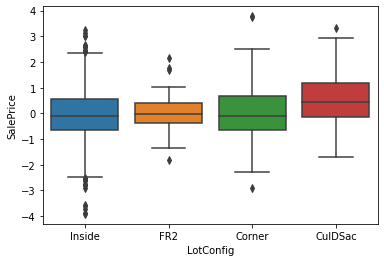

In [2206]:
sns.boxplot(x = 'LotConfig', y = 'SalePrice', data = train_df);

In [2207]:
replace_values(train_df, test_df, 'LotConfig', 'Inside', None)

In [2208]:
to_get_dummies.append('LotConfig')

**LandSlope**

In [2209]:
train_df['LandSlope'].value_counts()

Gtl    1381
Mod      65
Name: LandSlope, dtype: int64

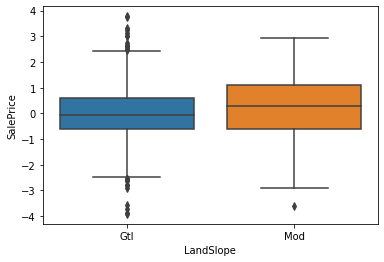

In [2210]:
sns.boxplot(x = 'LandSlope', y = 'SalePrice', data = train_df);

Выглядит неинформативно. 

In [2211]:
to_drop.append('LandSlope')

**Neighborhood**

In [2212]:
train_df['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Name: Neighborhood, dtype: int64

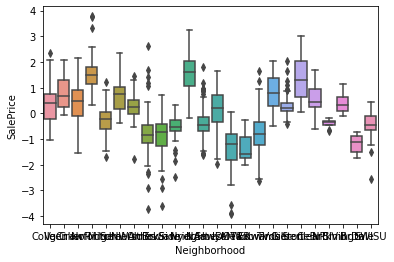

In [2213]:
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = train_df);

Выглядит 
1. Как какая-то мешанина снизу
2. Страшно посередине 
3. Обыденно сверху 
4. Информативно

In [2214]:
to_get_dummies.append('Neighborhood')

**Condition1**

In [2215]:
train_df['Condition1'].value_counts()

Norm      1259
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
Name: Condition1, dtype: int64

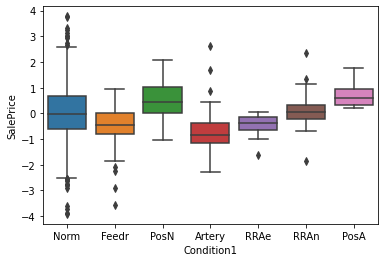

In [2216]:
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = train_df);

In [2217]:
replace_values(train_df, test_df, 'Condition1', 'Norm', None)

In [2218]:
to_get_dummies.append('Condition1')

**Condition2**

In [2219]:
train_df['Condition2'].value_counts()

Norm    1444
Name: Condition2, dtype: int64

In [2220]:
to_drop.append('Condition2')

**BldgType**

In [2221]:
train_df['BldgType'].value_counts()

1Fam      1219
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

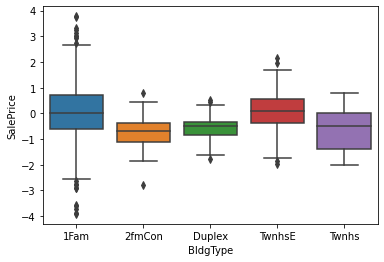

In [2222]:
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = train_df);

In [2223]:
replace_values(train_df, test_df, 'BldgType', '1Fam', None)

In [2224]:
to_get_dummies.append('BldgType')

**HouseStyle**

In [2225]:
train_df['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       64
SFoyer     37
2.5Unf     11
Name: HouseStyle, dtype: int64

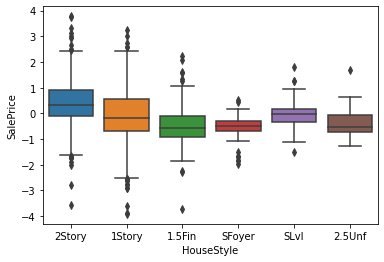

In [2226]:
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = train_df);

In [2227]:
replace_values(train_df, test_df, 'HouseStyle', '2Story', None)
replace_values(train_df, test_df, 'HouseStyle', '1Story', None)

In [2228]:
to_get_dummies.append('HouseStyle')

**RoofStyle**

In [2229]:
train_df['RoofStyle'].value_counts()

Gable      1140
Hip         286
Gambrel      11
Name: RoofStyle, dtype: int64

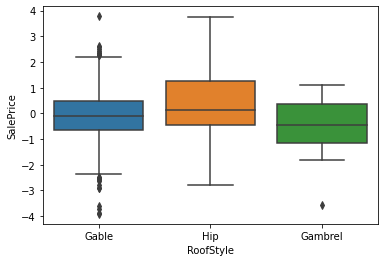

In [2230]:
sns.boxplot(x = 'RoofStyle', y = 'SalePrice', data = train_df);

In [2231]:
replace_values(train_df, test_df, 'RoofStyle', 'Gable', None)
to_drop.append('RoofStyle')

**RoofMatl**

In [2232]:
train_df['RoofMatl'].value_counts()

CompShg    1433
Tar&Grv      11
Name: RoofMatl, dtype: int64

In [2233]:
to_drop.append('RoofMatl')

**Exterior1st**

In [2234]:
train_df['Exterior1st'].value_counts()

VinylSd    514
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Name: Exterior1st, dtype: int64

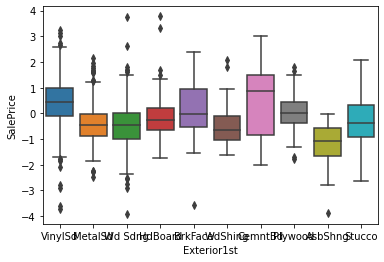

In [2235]:
sns.boxplot(x = 'Exterior1st', y = 'SalePrice', data = train_df);

In [2236]:
replace_values(train_df, test_df, 'Exterior1st', 'VinylSd', None)

In [2237]:
to_get_dummies.append('Exterior1st')

**Exterior2nd**

In [2238]:
train_df['Exterior2nd'].value_counts()

VinylSd    503
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
Name: Exterior2nd, dtype: int64

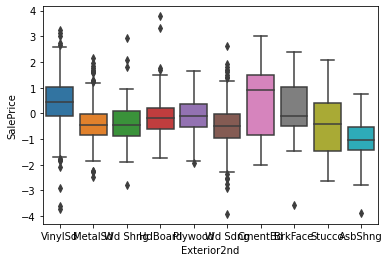

In [2239]:
sns.boxplot(x = 'Exterior2nd', y = 'SalePrice', data = train_df);

In [2240]:
replace_values(train_df, test_df, 'Exterior2nd', 'VinylSd', None)
replace_values(train_df, test_df, 'Exterior2nd', 'Wd Sdng', None)

In [2241]:
to_get_dummies.append('Exterior2nd')

**MasVnrType**

In [2242]:
train_df['MasVnrType'].value_counts()

None       863
BrkFace    445
Stone      128
BrkCmn      15
0            8
Name: MasVnrType, dtype: int64

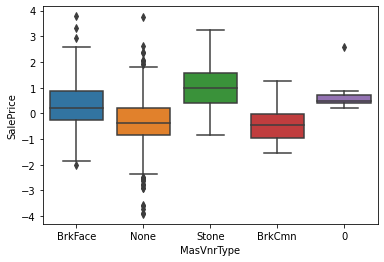

In [2243]:
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = train_df);

In [2244]:
replace_values(train_df, test_df, 'MasVnrType', 'None', None) # Лол

In [2245]:
to_get_dummies.append('MasVnrType')

**ExterQual**

In [2246]:
train_df['ExterQual'].value_counts()

TA    905
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

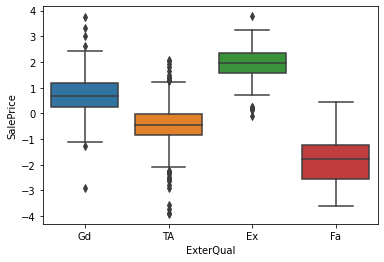

In [2247]:
sns.boxplot(x = 'ExterQual', y = 'SalePrice', data = train_df);

In [2248]:
to_get_dummies.append('ExterQual')

**ExterCond**

In [2249]:
train_df['ExterCond'].value_counts()

TA    1281
Gd     146
Fa      28
Name: ExterCond, dtype: int64

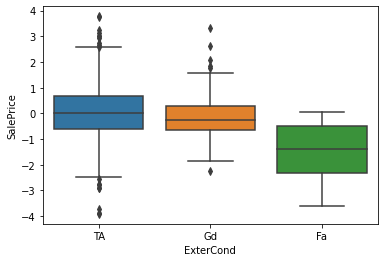

In [2250]:
sns.boxplot(x = 'ExterCond', y = 'SalePrice', data = train_df);

In [2251]:
replace_values(train_df, test_df, 'ExterCond', 'TA', None)

In [2252]:
to_get_dummies.append('ExterCond')

**Foundation**

In [2253]:
train_df['Foundation'].value_counts()

PConc     646
CBlock    634
BrkTil    146
Slab       24
Name: Foundation, dtype: int64

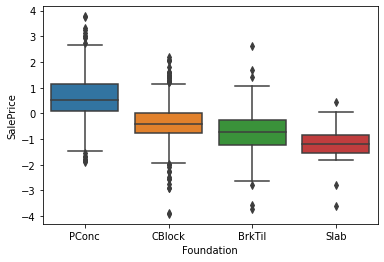

In [2254]:
sns.boxplot(x = 'Foundation', y = 'SalePrice', data = train_df);

In [2255]:
to_get_dummies.append('Foundation')

**BsmtQual**

In [2256]:
train_df['BsmtQual'].value_counts()

TA    649
Gd    617
Ex    121
0      37
Fa     35
Name: BsmtQual, dtype: int64

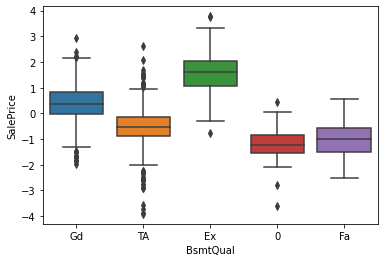

In [2257]:
sns.boxplot(x = 'BsmtQual', y = 'SalePrice', data = train_df);

In [2258]:
replace_values(train_df, test_df, 'BsmtQual', 'TA', None)

In [2259]:
to_get_dummies.append('BsmtQual')

**BsmtCond**

In [2260]:
train_df['BsmtCond'].value_counts()

TA    1310
Gd      65
Fa      45
0       37
Name: BsmtCond, dtype: int64

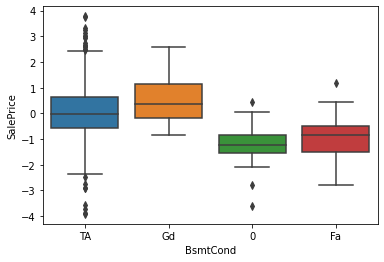

In [2261]:
sns.boxplot(x = 'BsmtCond', y = 'SalePrice', data = train_df);

In [2262]:
replace_values(train_df, test_df, 'BsmtCond', 'TA', None)

In [2263]:
to_get_dummies.append('BsmtCond')

**BsmtExposure**

In [2264]:
train_df['BsmtExposure'].value_counts()

No    952
Av    221
Gd    134
Mn    114
0      38
Name: BsmtExposure, dtype: int64

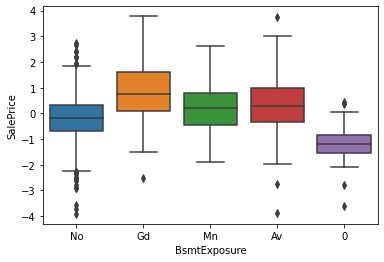

In [2265]:
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = train_df);

In [2266]:
replace_values(train_df, test_df, 'BsmtExposure', 'No', None)

In [2267]:
to_get_dummies.append('BsmtExposure')

**BsmtFinType1**

Вот тут надо быть чуть-чуть более аккуратным, ибо признак представляет собою оценку цокольного этажа (и 0, если оценивать нечего)  и, следовательно, есть надежда, что разумно просто поставить в соотсветствие каждой оценке некоторое число. 
Вот все возможные значения:

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       0	No Basement

In [2268]:
train_df['BsmtFinType1'].value_counts()

Unf    429
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
0       37
Name: BsmtFinType1, dtype: int64

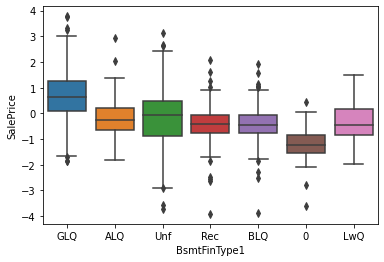

In [2269]:
sns.boxplot(x = 'BsmtFinType1', y = 'SalePrice', data = train_df);

В общем и целом, всё выглядит так, как и ожидалось, а именно, по мере увеличения оценки средняя стоимость домов неубывает, за тем лишь исключением, что по цене дома с незавершённой отделкой по каким-то причинам в среднем находятся где-то между ALQ и GLQ, но проблем это не создаёт.

In [2270]:
bft1_dict = {0: 0, 'LwQ': 1, 'Rec': 2, 'BLQ':3, 'ALQ': 4, 'Unf': 5, 'GLQ': 6} 
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].map(bft1_dict)
test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(bft1_dict)
label_encoded.append('BsmtFinType1')

**BsmtFinType2**

In [2271]:
train_df['BsmtFinType2'].value_counts()

Unf    1255
Rec      54
LwQ      46
0        38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

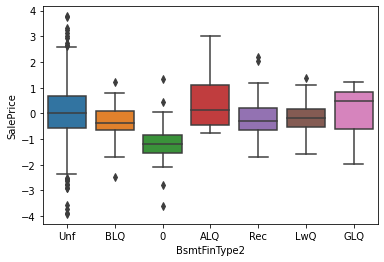

In [2272]:
sns.boxplot(x = 'BsmtFinType2', y = 'SalePrice', data = train_df);

In [2273]:
replace_values(train_df, test_df, 'BsmtFinType2', 'Unf', None)

In [2274]:
to_get_dummies.append('BsmtFinType2')

**Heating**

In [2275]:
train_df['Heating'].value_counts()

GasA    1427
GasW      18
Name: Heating, dtype: int64

In [2276]:
to_drop.append('Heating')

**HeatingQC**

In [2277]:
train_df['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    240
Fa     49
Name: HeatingQC, dtype: int64

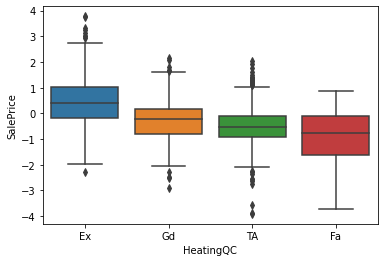

In [2278]:
sns.boxplot(x = 'HeatingQC', y = 'SalePrice', data = train_df);

In [2279]:
to_get_dummies.append('HeatingQC')

**CentralAir**

In [2280]:
train_df['CentralAir'].value_counts()

Y    1364
N      95
Name: CentralAir, dtype: int64

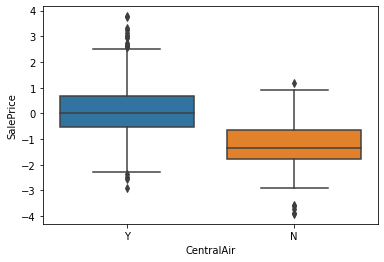

In [2281]:
sns.boxplot(x = 'CentralAir', y = 'SalePrice', data = train_df);

In [2282]:
# replace_values(train_df, test_df, 'CentralAir', 'Y', None)

In [2283]:
to_get_dummies.append('CentralAir')

**Electrical**

In [2284]:
train_df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
Name: Electrical, dtype: int64

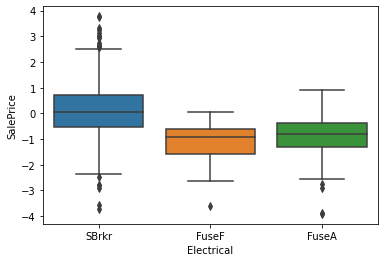

In [2285]:
sns.boxplot(x = 'Electrical', y = 'SalePrice', data = train_df);

In [2286]:
replace_values(train_df, test_df, 'Electrical', 'SBrkr', None)

In [2287]:
to_get_dummies.append('Electrical')

**KitchenQual**

In [2288]:
train_df['KitchenQual'].value_counts()

TA    735
Gd    585
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Снова оценка, но на этот раз качества кухни

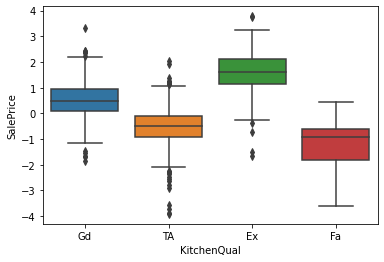

In [2289]:
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = train_df);

In [2290]:
# replace_values(train_df, test_df, 'KitchenQual', 'TA', None)

In [2291]:
to_get_dummies.append('KitchenQual')

**Functional**

In [2292]:
train_df['Functional'].value_counts()

Typ     1359
Min2      34
Min1      31
Mod       15
Name: Functional, dtype: int64

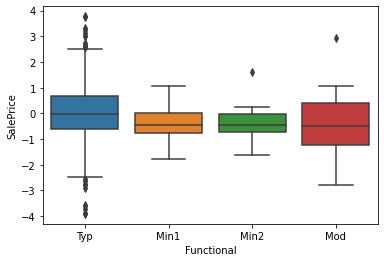

In [2293]:
sns.boxplot(x = 'Functional', y = 'SalePrice', data = train_df);

In [2294]:
replace_values(train_df, test_df, 'Functional', 'Typ', None)

In [2295]:
to_get_dummies.append('Functional')

**FireplaceQu**

In [2296]:
train_df['FireplaceQu'].value_counts()

0     689
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

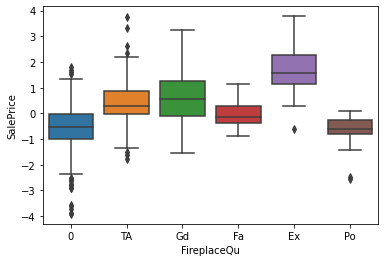

In [2297]:
sns.boxplot(x = 'FireplaceQu', y = 'SalePrice', data = train_df);

In [2298]:
# replace_values(train_df, test_df, 'FireplaceQu', 0, None)

In [2299]:
to_get_dummies.append('FireplaceQu')

**GarageType**

In [2300]:
train_df['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     87
0           81
Basment     19
Name: GarageType, dtype: int64

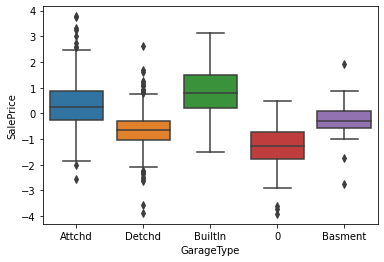

In [2301]:
sns.boxplot(x = 'GarageType', y = 'SalePrice', data = train_df);

In [2302]:
# replace_values(train_df, test_df, 'GarageType', 'Attchd', None)

In [2303]:
to_get_dummies.append('GarageType')

**GarageFinish**

In [2304]:
train_df['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    351
0       81
Name: GarageFinish, dtype: int64

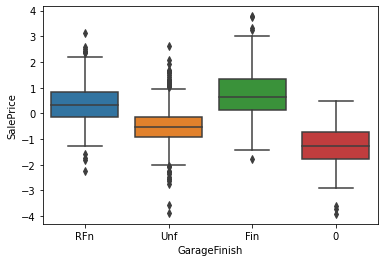

In [2305]:
sns.boxplot(x = 'GarageFinish', y = 'SalePrice', data = train_df);

In [2306]:
replace_values(train_df, test_df, 'GarageFinish', 'Unf', None)

In [2307]:
to_get_dummies.append('GarageFinish')

**GarageQual**

In [2308]:
train_df['GarageQual'].value_counts()

TA    1310
0       81
Fa      48
Gd      14
Name: GarageQual, dtype: int64

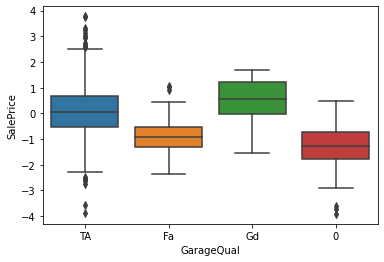

In [2309]:
sns.boxplot(x = 'GarageQual', y = 'SalePrice', data = train_df);

In [2310]:
# replace_values(train_df, test_df, 'GarageQual', 'TA', None)

In [2311]:
to_get_dummies.append('GarageQual')

**GarageCond**

In [2312]:
train_df['GarageCond'].value_counts()

TA    1325
0       81
Fa      35
Name: GarageCond, dtype: int64

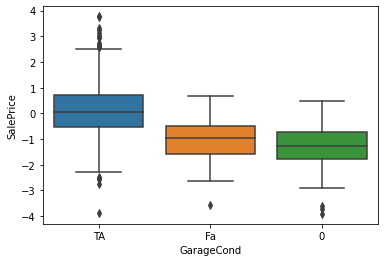

In [2313]:
sns.boxplot(x = 'GarageCond', y = 'SalePrice', data = train_df);

In [2314]:
replace_values(train_df, test_df, 'GarageCond', 'TA', None)

Признак нечаянно получился бинарным.

In [2315]:
to_get_dummies.append('GarageCond')

**PavedDrive**

In [2316]:
train_df['PavedDrive'].value_counts()

Y    1339
N      90
P      30
Name: PavedDrive, dtype: int64

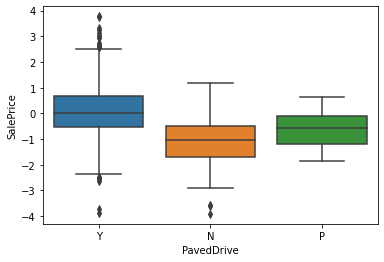

In [2317]:
sns.boxplot(x = 'PavedDrive', y = 'SalePrice', data = train_df);

In [2318]:
replace_values(train_df, test_df, 'PavedDrive', 'Y', None)

In [2319]:
to_drop.append('PavedDrive')

**Fence**

In [2320]:
train_df['Fence'].value_counts()

0        1178
MnPrv     157
GdPrv      59
GdWo       54
Name: Fence, dtype: int64

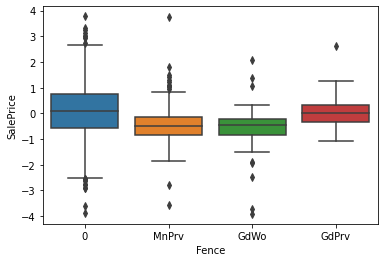

In [2321]:
sns.boxplot(x = 'Fence', y = 'SalePrice', data = train_df);

In [2322]:
replace_values(train_df, test_df, 'Fence', 0, None)

In [2323]:
to_drop.append('Fence')

**SaleType**

In [2324]:
train_df['SaleType'].value_counts()

WD       1266
New       122
COD        43
ConLD       9
Name: SaleType, dtype: int64

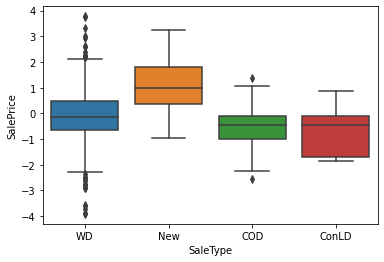

In [2325]:
sns.boxplot(x = 'SaleType', y = 'SalePrice', data = train_df);

In [2326]:
replace_values(train_df, test_df, 'SaleType', 'WD', None)
# Слишком сильный разброс для значения, которое встречается всего 9 раз
replace_values(train_df, test_df, 'SaleType', 'ConLD', None)

In [2327]:
to_get_dummies.append('SaleType')

**SaleCondition**

In [2328]:
train_df['SaleCondition'].value_counts()

Normal     1197
Partial     125
Abnorml     101
Family       20
Alloca       12
Name: SaleCondition, dtype: int64

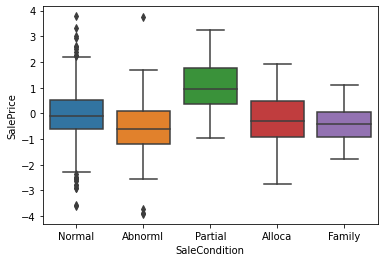

In [2329]:
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = train_df);

In [2330]:
replace_values(train_df, test_df, 'SaleCondition', 'Normal', None)

In [2331]:
to_get_dummies.append('SaleCondition')

**MSSubClass**

In [2332]:
train_df['MSSubClass'].value_counts()

20.0     536
60.0     299
50.0     144
120.0     87
30.0      69
160.0     63
70.0      60
80.0      57
90.0      52
190.0     30
85.0      20
Name: MSSubClass, dtype: int64

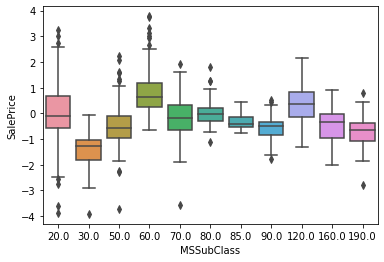

In [2333]:
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = train_df);

In [2334]:
replace_values(train_df, test_df, 'MSSubClass', 20.0, None)

In [2335]:
to_get_dummies.append('MSSubClass')

**GarageCars**

In [2336]:
train_df['GarageCars'].value_counts()

2.0    823
1.0    369
3.0    181
0.0     81
Name: GarageCars, dtype: int64

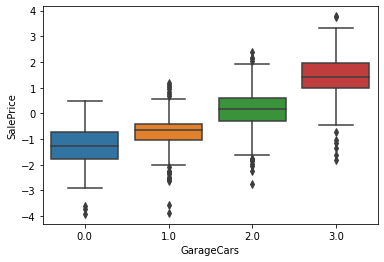

In [2337]:
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = train_df);

Оставляем как есть. Только предварительно заменим отсутсвующие значения модой

In [2338]:
train_df.loc[train_df['GarageCars'].isna(), 'GarageCars'] = 2.0
test_df.loc[test_df['GarageCars'].isna(), 'GarageCars'] = 2.0
label_encoded.append('GarageCars')

**GarageCars**

In [2339]:
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

Убедимся в том, что я не идиот и что после всего этого в тренировочном наборе ровно такие же признаки, какие и в тестовом (кроме, разумеется, целевой переменной):

In [2340]:
if set(train_df.columns) - set(['SalePrice']) == set(test_df.columns):
    print('Удивительно, но ты не идиот')
else:
    print('Ничего удивительного')

Удивительно, но ты не идиот


Действительно удивительно...

## Анализ вещественнозначных переменных

In [2341]:
to_drop = []

Поскольку вещественных признаков не так уж и много, я поглядел на все разом. Предлагаю сделать это и вам за тем лишь исключением, что вам я услужливо покрашу в красный цвет графики тех признаков, которые чуть более, чем бесполезны 

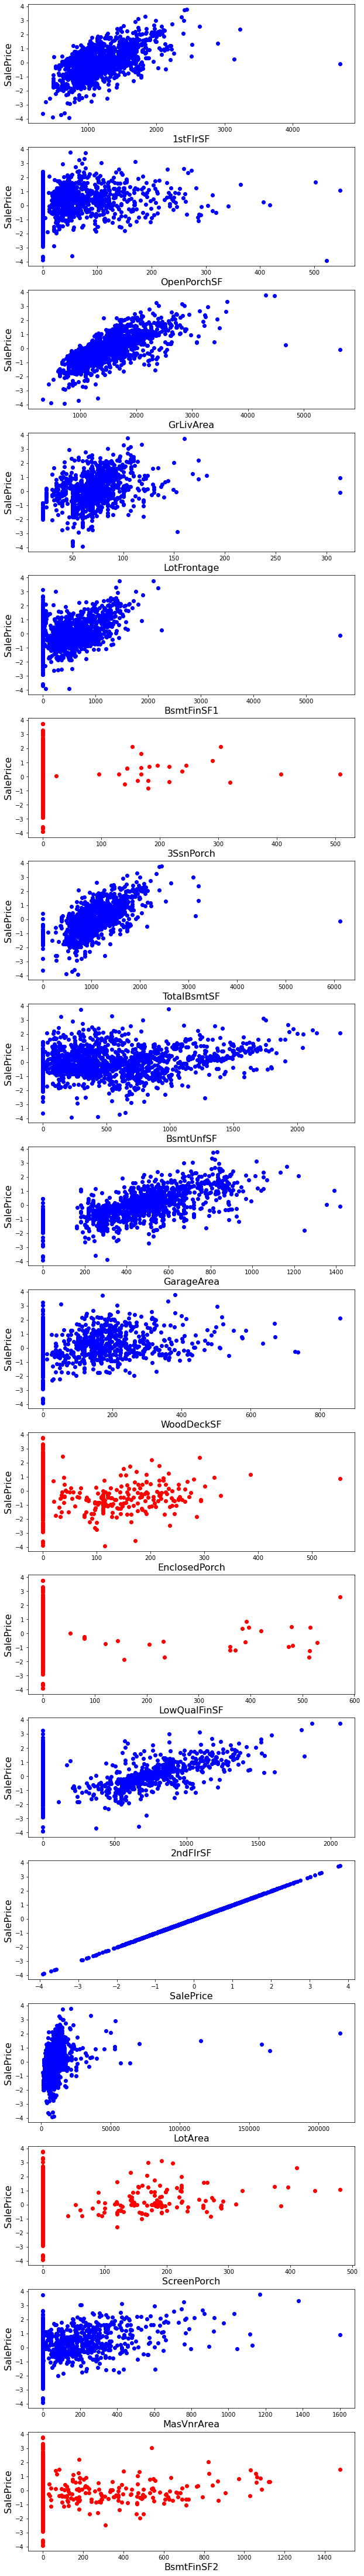

In [2342]:
is_useless = ['3SsnPorch', 'LowQualFinSF', 'ScreenPorch', 'BsmtFinSF2', 'EnclosedPorch']
fig, axs = plt.subplots(len(real_features), 1, figsize = (10, 80))
for (i, f) in enumerate(real_features):
    axs[i].scatter(train_df[f], train_df['SalePrice'], color = 'red' if f in is_useless else 'blue');
    axs[i].set_xlabel(f, fontsize = 16)
    axs[i].set_ylabel('SalePrice', fontsize = 16);

In [2343]:
train_df.drop(is_useless, axis = 1, inplace = True)
test_df.drop(is_useless, axis = 1, inplace = True)

In [2344]:
real_features = list(set(real_features) - set(is_useless))

In [2345]:
real_features

['1stFlrSF',
 'OpenPorchSF',
 'GrLivArea',
 'LotFrontage',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'WoodDeckSF',
 'GarageArea',
 '2ndFlrSF',
 'SalePrice',
 'LotArea',
 'MasVnrArea']

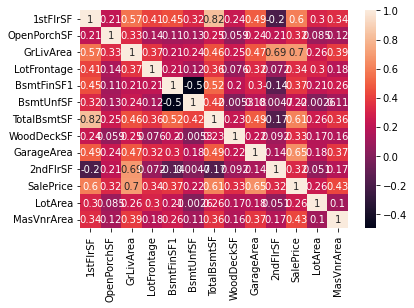

In [2346]:
sns.heatmap(train_df[real_features].corr(), annot = True);

Интересного мало (кроме того, что между площадью первого и второго этажа отрицательная корреляция o_О)

**GrLivArea**

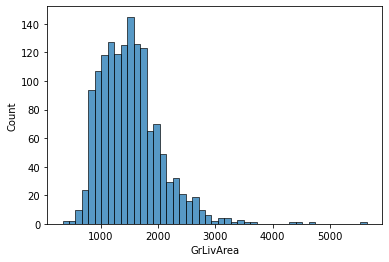

In [2347]:
sns.histplot(x = 'GrLivArea', data = train_df);

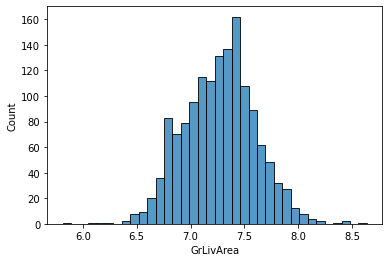

In [2348]:
sns.histplot(np.log(train_df['GrLivArea']));

Так распределение больше походит на нормальное, а нормально распределение - это всегда хорошо

In [2349]:
grliv = np.log(train_df['GrLivArea'].copy())
scipy.stats.shapiro(grliv)

ShapiroResult(statistic=0.9960801601409912, pvalue=0.0008425545529462397)

C:\Users\onton\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


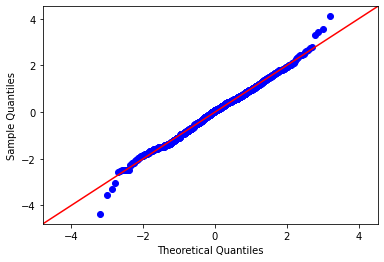

In [2350]:
smapi.qqplot((grliv - grliv.mean()) / grliv.std(), line = '45');

Аналогично с целевой переменной, т.е считаем, что распределение незначительно отличается от нормального, а значит имеет смысл этот признак прологарифмировать

In [2351]:
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])
test_df['GrLivArea'] = np.log(test_df['GrLivArea'])
del grliv

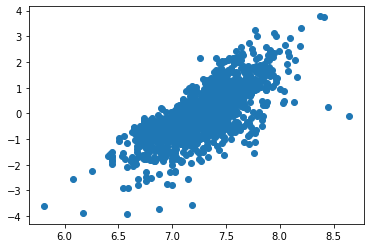

In [2352]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice']);

Просто конфетка

**BsmtUnfSF**

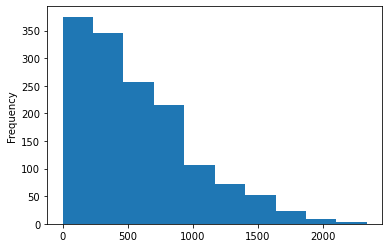

In [2353]:
train_df['BsmtUnfSF'].plot.hist();

Похоже на экспоненциальное распределение. Посмотрим поближе

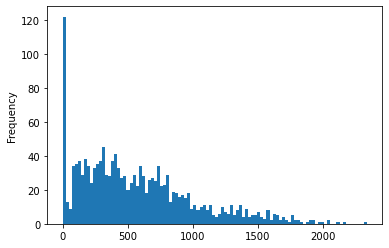

In [2354]:
train_df['BsmtUnfSF'].plot.hist(bins = 100);

А нет, не очень-то и похоже :(

Более того, не похоже и на нормальное, ибо 
1. Куча нулей
2. Если и убрать нули, но распределение получится не "скошенным" влево, а "начинающимся" слева

Посмотрим на зависимость цены от этого признака

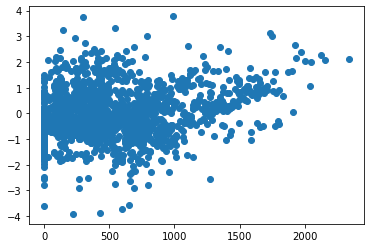

In [2355]:
plt.scatter(train_df['BsmtUnfSF'], train_df['SalePrice']);

Ничего разумнее, чем оставить всё как есть и надеяться на лучшее, предложить не могу

**LotArea**

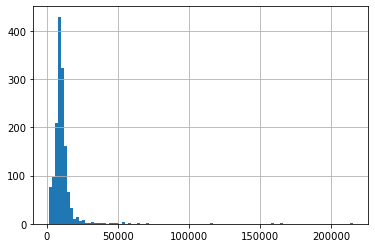

In [2356]:
train_df['LotArea'].hist(bins = 100);

Ох ё. Выбросов (в т.ч экстремальных) довольно много. Посмотрим поближе.

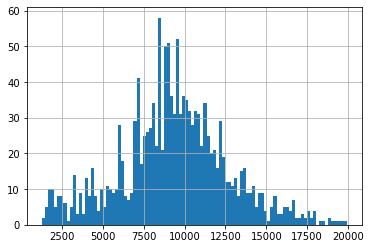

In [2357]:
train_df[train_df['LotArea'] < 20000]['LotArea'].hist(bins = 100);

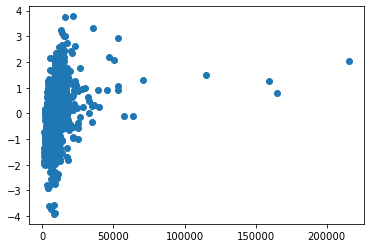

In [2358]:
plt.scatter(train_df['LotArea'], train_df['SalePrice']);

Ничего содержательного снова предложить не могу

**WoodDeckSF**

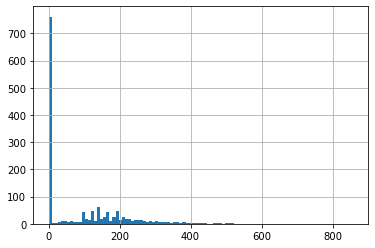

In [2359]:
train_df['WoodDeckSF'].hist(bins = 100);

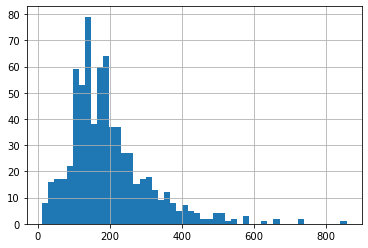

In [2360]:
train_df[train_df['WoodDeckSF'] != 0]['WoodDeckSF'].hist(bins = 50);

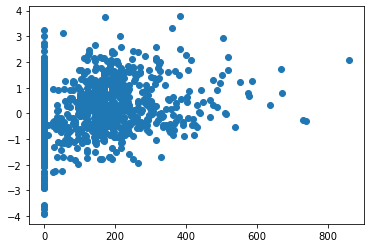

In [2361]:
plt.scatter(train_df['WoodDeckSF'], train_df['SalePrice']);

Аналогично :(

**BsmtFinSF1**

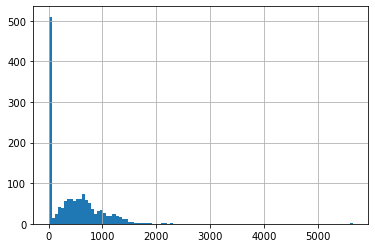

In [2362]:
train_df['BsmtFinSF1'].hist(bins = 100);

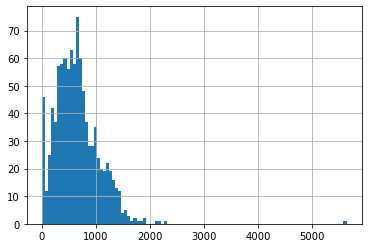

In [2363]:
train_df[train_df['BsmtFinSF1'] != 0]['BsmtFinSF1'].hist(bins = 100);

Выглядит чуть менее плохо

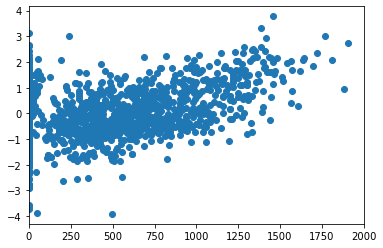

In [2364]:
plt.scatter(train_df['BsmtFinSF1'], train_df['SalePrice']);
plt.xlim((0, 2000));

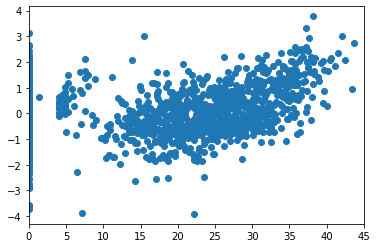

In [2365]:
plt.scatter(np.sqrt(train_df['BsmtFinSF1']), train_df['SalePrice']);
plt.xlim((0, 45));

Ну, хотя бы виден какой-то +- чёткий тренд (если закрыть глаза на обилие нулей, конечно же)

**GarageArea**

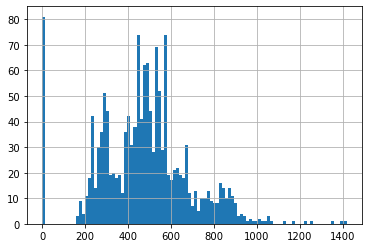

In [2366]:
train_df['GarageArea'].hist(bins = 100);

Распределение походит на бимодальное, так что разумно было бы предусмотреть для этого признака отдельный вид нормализации, но [как обычно](http://lurkmore.to/Всем_похуй)

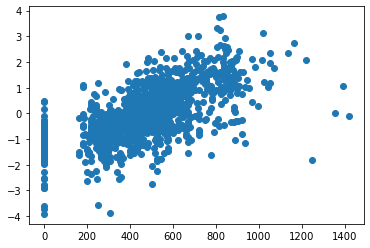

In [2367]:
plt.scatter(train_df['GarageArea'], train_df['SalePrice']);

Какой-никакой тренд тоже виден

**2ndFlrSF**

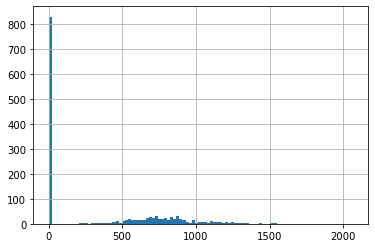

In [2368]:
train_df['2ndFlrSF'].hist(bins = 100);

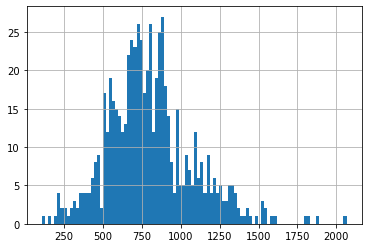

In [2369]:
train_df[train_df['2ndFlrSF'] != 0]['2ndFlrSF'].hist(bins = 100);

Нечто, походящее на нормальное распределение, но, скажем так, не слишком

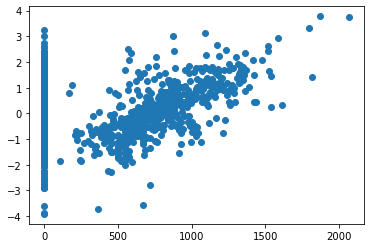

In [2370]:
plt.scatter(train_df['2ndFlrSF'], train_df['SalePrice']);

Тоже выглядит несколько полезно

**TotalBsmtSF**

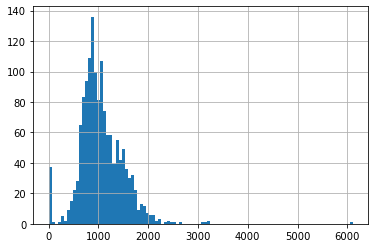

In [2371]:
train_df['TotalBsmtSF'].hist(bins = 100);

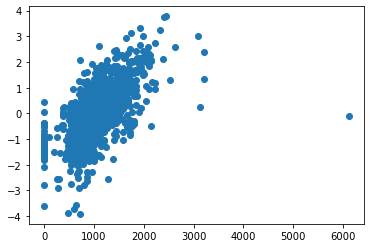

In [2372]:
plt.scatter(train_df['TotalBsmtSF'], train_df['SalePrice']);

Всё то же 

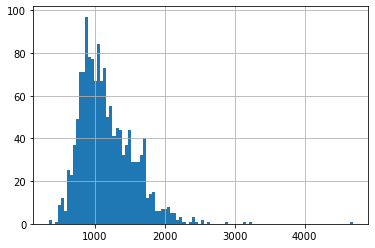

In [2373]:
train_df['1stFlrSF'].hist(bins = 100);

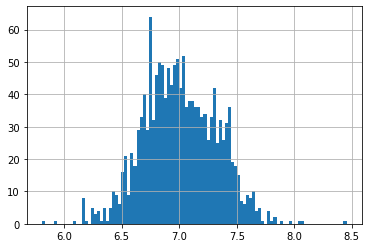

In [2374]:
np.log(train_df['1stFlrSF']).hist(bins = 100);

Весьма и весьма походит на нормально распределение. К тому же, критерий Шапиро-Уилка отвергает гипотезу с относительно высоким p-value

In [2375]:
scipy.stats.shapiro(np.log(train_df['1stFlrSF']))

ShapiroResult(statistic=0.9957446455955505, pvalue=0.0004081394581589848)

C:\Users\onton\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


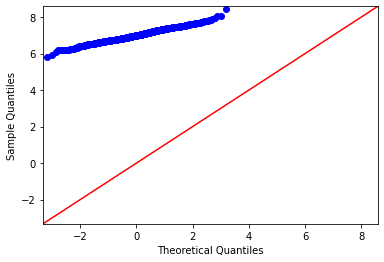

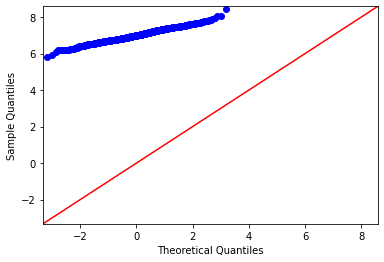

In [2376]:
smapi.qqplot(np.log(train_df['1stFlrSF']), line = '45')

Визуально отклонение от нормальности тоже не выглядят критичными

In [2377]:
train_df['1stFlrSF'] = np.log(train_df['1stFlrSF'])
test_df['1stFlrSF'] = np.log(test_df['1stFlrSF'])

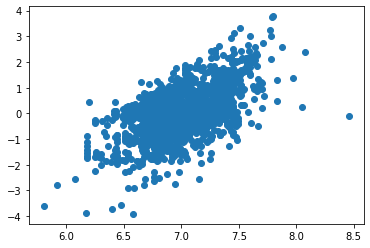

In [2378]:
plt.scatter(train_df['1stFlrSF'], train_df['SalePrice']);

**OpenPorchSF**

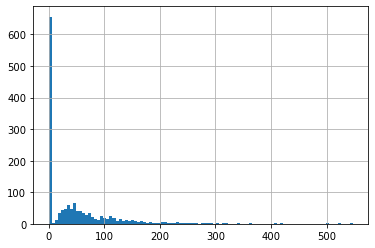

In [2379]:
train_df['OpenPorchSF'].hist(bins = 100);

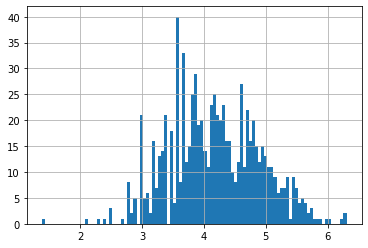

In [2380]:
loged_opsf = np.log(train_df[train_df['OpenPorchSF'] != 0]['OpenPorchSF'])
loged_opsf.hist(bins = 100);

In [2381]:
scipy.stats.shapiro(loged_opsf)

ShapiroResult(statistic=0.994683563709259, pvalue=0.006532903760671616)

C:\Users\onton\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


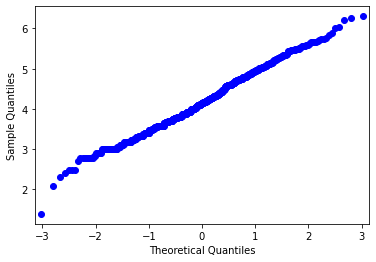

In [2382]:
smapi.qqplot(loged_opsf);

Собственно, та же песня, только нормально распределены ненулевые значения, в силу наличия которых будем брать не логарифм от признака, а логарифм от признака плюс один, что логично: нули останутся нулями, а никакая информация о ненулевых значениях потеряна не будет 

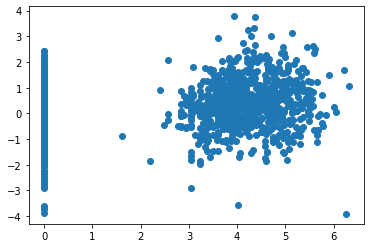

In [2383]:
plt.scatter(np.log(train_df['OpenPorchSF'] + 1), train_df['SalePrice']);

Характер зависимость скорее напоминает случайный, но имеем что имеем

In [2384]:
train_df['OpenPorchSF'] = np.log(train_df['OpenPorchSF'] + 1)
test_df['OpenPorchSF'] = np.log(test_df['OpenPorchSF'] + 1)

# Генерация признаков

Пока что будем считать, что категориальных признаков нам и без того хватает и займёмся признаками вещественными

Поскольку хотелось бы получить признаки без кучи нулей, посмотрим на признаки без них

In [2385]:
for feat in real_features:
    num_zeroes = (train_df[feat] == 0).sum()
    if num_zeroes == 0 and feat != 'SalePrice':
        print(f'{feat} has no zero values')

1stFlrSF has no zero values
GrLivArea has no zero values
LotFrontage has no zero values
LotArea has no zero values


**GrLivArea и 1stFlrSF**

GrLivArea и 1stFlrSF лучше всего перемножить.

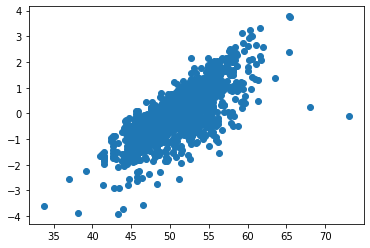

In [2386]:
plt.scatter(train_df['GrLivArea'] * train_df['1stFlrSF'], train_df['SalePrice']);

Выглядит как тавтология в том смысле, очень похожая картинка у "GrLivArea" и "1stFlrSF" по отдельности, но хуже стать явно не должно

In [2387]:
train_df['GrLiv * 1sFlr'] = train_df['GrLivArea'] * train_df['1stFlrSF']
test_df['GrLiv * 1sFlr'] = test_df['GrLivArea'] * test_df['1stFlrSF']

In [2388]:
real_features.append('GrLiv * 1sFlr')

**LotArea и 1stFlrSF**

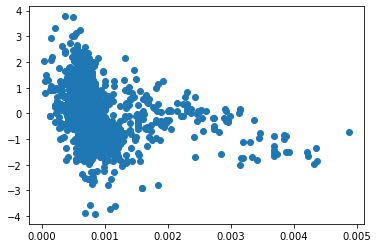

In [2389]:
plt.scatter(train_df['1stFlrSF'] / train_df['LotArea'], train_df['SalePrice']);

Такое себе

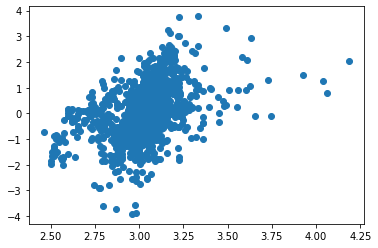

In [2390]:
plt.scatter(np.power(train_df['1stFlrSF'] * train_df['LotArea'], 1/10), train_df['SalePrice']);

Получше

In [2391]:
train_df['pow(1stFlrSF * LotArea. 1/10)'] = np.power(train_df['1stFlrSF'] * train_df['LotArea'], 1/10)
test_df['pow(1stFlrSF * LotArea. 1/10)'] = np.power(test_df['1stFlrSF'] * test_df['LotArea'], 1/10)
real_features.append('pow(1stFlrSF * LotArea. 1/10)')

**GrLivArea и LotArea**

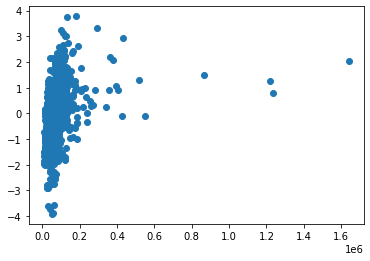

In [2392]:
plt.scatter(train_df['GrLivArea'] * train_df['LotArea'], train_df['SalePrice']);

Выглядит не особо привлекательно не в последнюю очередь из-за слишком больших значений по оси абсцисс. Попробуем несколько иначе

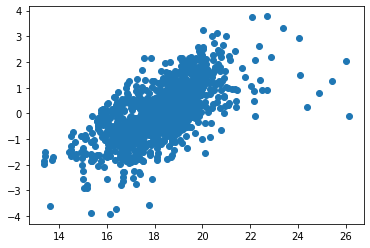

In [2393]:
plt.scatter(train_df['GrLivArea'] * np.power(train_df['LotArea'], 1 / 10), train_df['SalePrice']);

Выглядит куда более приятно.

In [2394]:
train_df['GrLivArea * pow(LotArea. 1/10)'] = train_df['GrLivArea'] * np.power(train_df['LotArea'], 1 / 10)
test_df['GrLivArea * pow(LotArea. 1/10)'] = test_df['GrLivArea'] * np.power(test_df['LotArea'], 1 / 10)
real_features.append('GrLivArea * pow(LotArea. 1/10)')

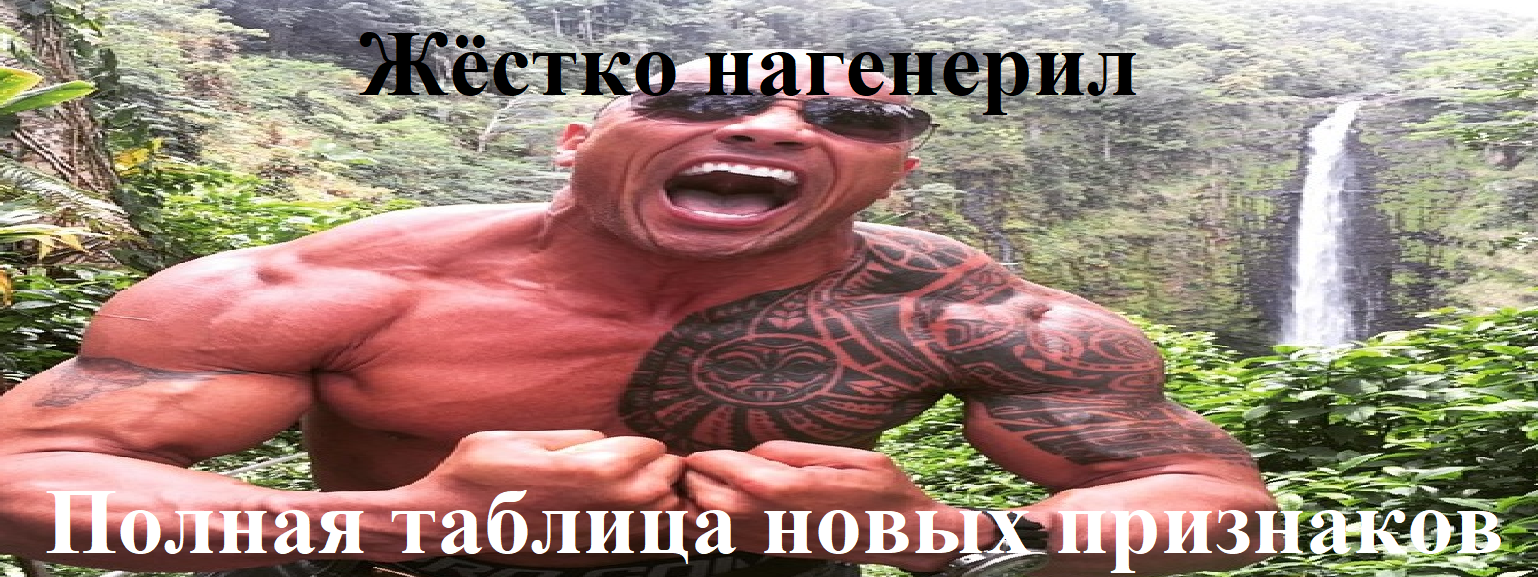

P.S Интересно отметить, что после добавления этих признаков качестве алгоритмов, не основанных на деревьях заметно улучшилось, но имело место нечто вроде аналога мультиколлинеарности для алгоритмах, основанных на деревьях, ибо их результаты стали несколько хуже. Объяснение, как по мне, такое: 

Пусть $S$ - некоторое подмножество признаков, а $A$ и $B$ - такие признаки, что в таблице так же есть признак, например, $A * B$. В таком случае, два дерева, что обучались на признаках $S \cup {A}$ и $S \cup {A * B}$ или $S \cup {B}$ и $S \cup {A * B}$ по сути располагали одинаковой информацией и становились сильно похожими 

# Сохранение некоторых данных и переменных для использования в другом блокноте

В последующем блокноте мы при валидации будем стандартизировать тестовые блоки отдельно от тестовых, так что вернём ценам изначальный масштаб

In [2395]:
train_df['SalePrice'] = train_df['SalePrice'] * sp_std + sp_mean

In [2396]:
# Лучше поостеречься ситуации, при которой мы где-то выше удалили строку где-то из середины,
# ибо возникнут некоторые проблемы при валидации
train_df.index = pd.RangeIndex(start = 0, stop = len(train_df))
test_df.index = pd.RangeIndex(start = 0, stop = len(test_df))

train_df = pd.get_dummies(train_df, columns = to_get_dummies)
test_df = pd.get_dummies(test_df, columns = to_get_dummies)

train_df_x = train_df.drop('SalePrice', axis = 1).copy()
train_df_y = train_df['SalePrice'].copy()

In [2397]:
train_df_x.to_csv(r'processed_data\train_df_x.csv')
train_df_y.to_csv(r'processed_data\train_df_y.csv')
test_df.to_csv(r'processed_data\test_df.csv')

Признаки, подлежащие стандартизации. SalePrice сюда не входит, ибо отныне он стоит особняком в train_df_y

In [2398]:
import pickle 
features_to_standard = list(set(real_features) - set(is_useless) - set(['SalePrice']))
features_to_standard = list(set(features_to_standard) ^ set(label_encoded))

with open(r'processed_data\features_to_standard.pickle', 'wb') as f:
    pickle.dump(features_to_standard, f)